In [1]:
import sys
import os

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

print("Path configurado para importar módulos de 'chemai':")
print(ROOT_DIR)


from proxy import configure_proxy
configure_proxy(ROOT_DIR)


Path configurado para importar módulos de 'chemai':
c:\Users\f0pi\git\viscosidade-ai
Proxy configurado.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression


from chemai.loader import DipprDatasetLoader
from chemai.chem_featurizer import ChemFeaturizer
from chemai.train import train_test_split

import random

In [3]:
GLOBAL_SEED = 13
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
os.environ["PYTHONHASHSEED"] = str(GLOBAL_SEED)

In [4]:
data_loader = DipprDatasetLoader(data_dir='../data/nist_dippr_data')
data_loader.prepare()

pure = data_loader.get_pure()
mix  = data_loader.get_mix()

pure_train, pure_dev = train_test_split(
    smiles1=pure['train']["MOL"],
    T=pure['train']["T"],
    logV=pure['train']["logV"]
)
pure_test = pure['test']  # conjunto final de teste

mix_train, mix_dev = train_test_split(
    smiles1=mix['train']["MOL_1"],
    smiles2=mix['train']["MOL_2"],
    MolFrac_1=mix['train']["MolFrac_1"],
    T=mix['train']["T"],
    logV=mix['train']["logV"]
)
mix_test = mix['test']  # conjunto final de teste

print(f"Puro: train={len(pure_train['smiles'])}, dev={len(pure_dev['smiles'])}, test={pure_test.shape[0]}")
print(f"Mix: train={len(mix_train['smiles_1'])}, dev={len(mix_dev['smiles_1'])}, test={mix_test.shape[0]}")


Puro: train=5268, dev=1450, test=885
Mix: train=20635, dev=5254, test=5585


In [ ]:
df = mix_test.drop('logV', axis=1).copy()
df.columns = ['smile_1', 'smile_2', 'fraction', 'temperature']
df.to_csv('../data/test.csv', index=False)

: 

In [14]:
chem = ChemFeaturizer()

df_train_pure = pd.DataFrame({'MOL': pure_train['smiles'], 'T': pure_train['T'], 'logV': pure_train['logV']})

df_train_mix = pd.DataFrame({
    'MOL_1': mix_train['smiles_1'], 'MOL_2': mix_train['smiles_2'],
    'MolFrac_1': mix_train['MolFrac_1'], 'T': mix_train['T'], 'logV': mix_train['logV']})

feat_train_pure_chem = chem.featurize_pure(df_train_pure)
feat_train_mix_chem = chem.featurize_mix_parallel(df_train_mix)

In [15]:
def build_pipeline(model, X_sample, embedding_features=False, k_features=50):
    if not embedding_features:
        cols = list(X_sample.columns)
        ignore = [c for c in cols if c.startswith('has_') or c == 'frac']

        floats = [c for c in cols 
                  if np.issubdtype(X_sample[c].dtype, np.floating) and c not in ignore]
        ints = [c for c in cols 
                if np.issubdtype(X_sample[c].dtype, np.integer) and c not in ignore]

        transformers = []
        if floats: transformers.append(('float_scaler', StandardScaler(), floats))
        if ints: transformers.append(('int_scaler', MinMaxScaler(), ints))
        if ignore: transformers.append(('skip', 'passthrough', ignore))

        col_transform = ColumnTransformer(transformers)
        pipeline = Pipeline([
            ('scaler', col_transform),
            ('imputer', SimpleImputer(strategy='median')),
            ('kbest', SelectKBest(score_func=f_regression, k=k_features))
        ])
        return pipeline

In [17]:
X_pure = feat_train_pure_chem.drop(columns=['logV'])
y_pure = feat_train_pure_chem['logV']

pipe_pure = build_pipeline(None, X_pure, embedding_features=False, k_features=50)
X_pure_transformed = pipe_pure.fit_transform(X_pure, y_pure)

selected_cols_pure = X_pure.columns[pipe_pure.named_steps['kbest'].get_support()]
df_pure_sel = pd.DataFrame(X_pure_transformed, columns=selected_cols_pure)

print(f"Total de variáveis originais: {X_pure.shape[1]}")
print(f"Variáveis selecionadas (Top {len(selected_cols_pure)}):")
print(selected_cols_pure.tolist())


Total de variáveis originais: 89
Variáveis selecionadas (Top 50):
['peso_molecular', 'peso_molecular_heavy', 'peso_molecular_exato', 'eletrons_valencia', 'tpsa', 'logp', 'molar_refractivity', 'lig_rotacionais', 'frac_csp3', 'kappa1', 'kappa2', 'kappa3', 'balabanJ', 'bertzCT', 'Chi0', 'Chi1', 'Chi0v', 'Chi1v', 'Chi3v', 'num_rings', 'num_aromatic_rings', 'num_aliphatic_rings', 'num_saturated_heterocycles', 'num_aliphatic_carbocycles', 'num_heteroatoms', 'max_abs_partial_charge', 'min_abs_partial_charge', 'max_partial_charge', 'min_partial_charge', 'labute_asa', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA7', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA5', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'EState_VSA9', 'Br', 'has_acid', 'has_ether']


In [ ]:
X_mix = feat_train_mix_chem.drop(columns=['logV'])
y_mix = feat_train_mix_chem['logV']

pipe_mix = build_pipeline(None, X_mix, embedding_features=False, k_features=50)
X_mix_transformed = pipe_mix.fit_transform(X_mix, y_mix)

selected_cols_mix = X_mix.columns[pipe_mix.named_steps['kbest'].get_support()]
df_mix_sel = pd.DataFrame(X_mix_transformed, columns=selected_cols_mix)

print(f"Total de variáveis originais: {X_mix.shape[1]}")
print(f"Variáveis selecionadas (Top {len(selected_cols_mix)}):")
print(selected_cols_mix.tolist())


Total de variáveis originais: 178
Variáveis selecionadas (Top 50):
['mol1_peso_molecular', 'mol1_peso_molecular_heavy', 'mol1_peso_molecular_exato', 'mol1_eletrons_valencia', 'mol1_tpsa', 'mol1_lig_rotacionais', 'mol1_kappa3', 'mol1_balabanJ', 'mol1_bertzCT', 'mol1_Chi0', 'mol1_Chi1', 'mol1_Chi0v', 'mol1_Chi1v', 'mol1_num_rings', 'mol1_num_aromatic_rings', 'mol1_num_aliphatic_rings', 'mol1_labute_asa', 'mol1_PEOE_VSA12', 'mol1_SlogP_VSA1', 'mol1_SlogP_VSA10', 'mol1_SlogP_VSA11', 'mol1_EState_VSA1', 'mol1_EState_VSA10', 'mol1_EState_VSA7', 'mol1_has_acid', 'mol1_has_urea', 'mol1_has_ether', 'mol2_lig_rotacionais', 'mol2_hall_kier_alpha', 'mol2_kappa1', 'mol2_kappa2', 'mol2_Chi0', 'mol2_Chi0v', 'mol2_Chi2v', 'mol2_num_aromatic_heterocycles', 'mol2_num_saturated_carbocycles', 'mol2_num_heteroatoms', 'mol2_formal_charge', 'mol2_min_abs_partial_charge', 'mol2_max_partial_charge', 'mol2_min_partial_charge', 'mol2_labute_asa', 'mol2_PEOE_VSA6', 'mol2_SlogP_VSA11', 'mol2_SlogP_VSA5', 'mol2_Slo

In [19]:
display(df_pure_sel.describe().T.round(3))
display(df_mix_sel.describe().T.round(3))

,count,mean,std,min,25%,50%,75%,max
peso_molecular,5268.0,0.000,1.000,-1.581,-0.510,-0.131,0.278,12.357
peso_molecular_heavy,5268.0,-0.000,1.000,-1.554,-0.530,-0.154,0.256,12.247
peso_molecular_exato,5268.0,0.000,1.000,-1.582,-0.508,-0.130,0.281,12.369
eletrons_valencia,5268.0,-0.000,1.000,-1.086,-1.086,0.191,0.574,5.524
tpsa,5268.0,0.000,1.000,-1.720,-0.567,-0.101,0.407,13.202
logp,5268.0,-0.000,1.000,-2.017,-0.626,0.766,0.766,0.766
molar_refractivity,5268.0,0.000,1.000,-6.643,-0.521,0.290,0.362,4.328
lig_rotacionais,5268.0,0.000,1.000,-1.712,-0.508,-0.213,0.280,13.150
frac_csp3,5268.0,-0.000,1.000,-5.650,-0.261,-0.083,0.282,8.782
kappa1,5268.0,-0.000,1.000,-3.825,-0.479,0.142,0.500,6.157


,count,mean,std,min,25%,50%,75%,max
mol1_peso_molecular,41270.0,0.000,1.000,-1.859,-0.647,-0.136,0.501,6.760
mol1_peso_molecular_heavy,41270.0,-0.000,1.000,-1.843,-0.587,-0.213,0.438,6.210
mol1_peso_molecular_exato,41270.0,0.000,1.000,-1.864,-0.647,-0.134,0.505,6.784
mol1_eletrons_valencia,41270.0,-0.000,1.000,-1.300,-1.300,0.204,0.655,4.566
mol1_tpsa,41270.0,0.000,1.000,-1.866,-0.587,-0.164,0.427,7.828
mol1_lig_rotacionais,41270.0,-0.000,1.000,-1.739,-0.575,-0.186,0.265,7.889
mol1_kappa3,41270.0,-0.000,1.000,-2.427,-0.583,-0.139,0.366,7.767
mol1_balabanJ,41270.0,-0.000,1.000,-2.134,-0.655,-0.180,0.416,7.117
mol1_bertzCT,41270.0,0.000,1.000,-1.968,-0.573,-0.099,0.331,8.054
mol1_Chi0,41270.0,-0.000,1.000,-1.788,-0.541,-0.150,0.376,10.337


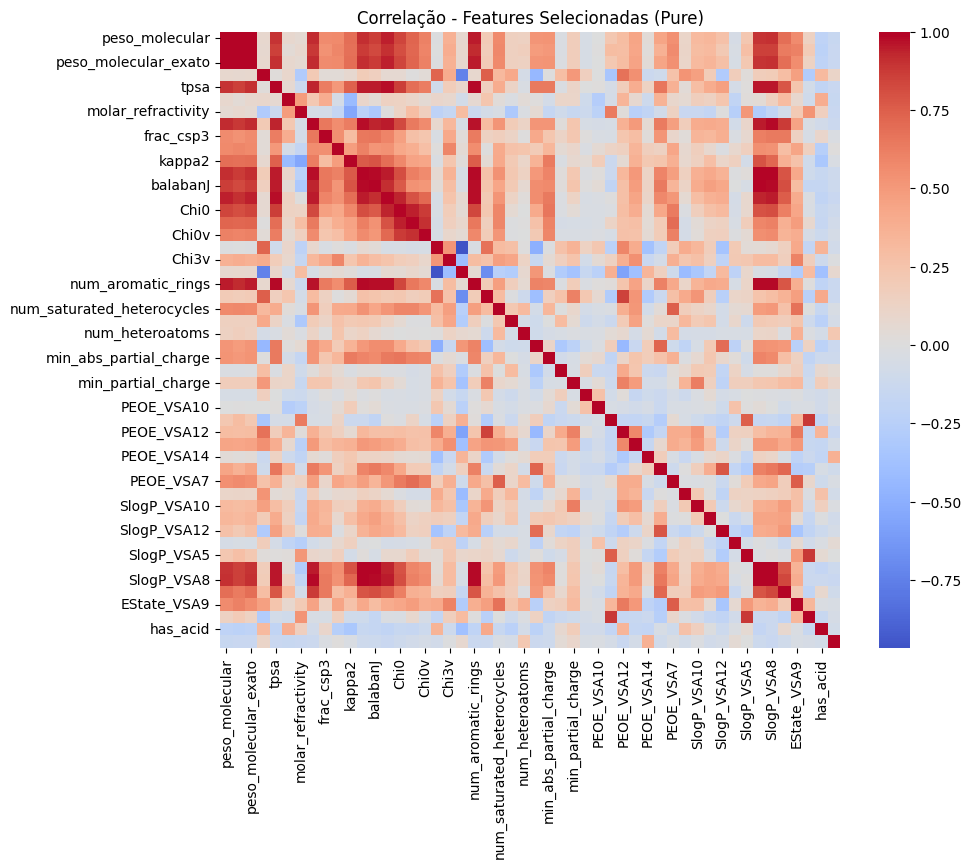

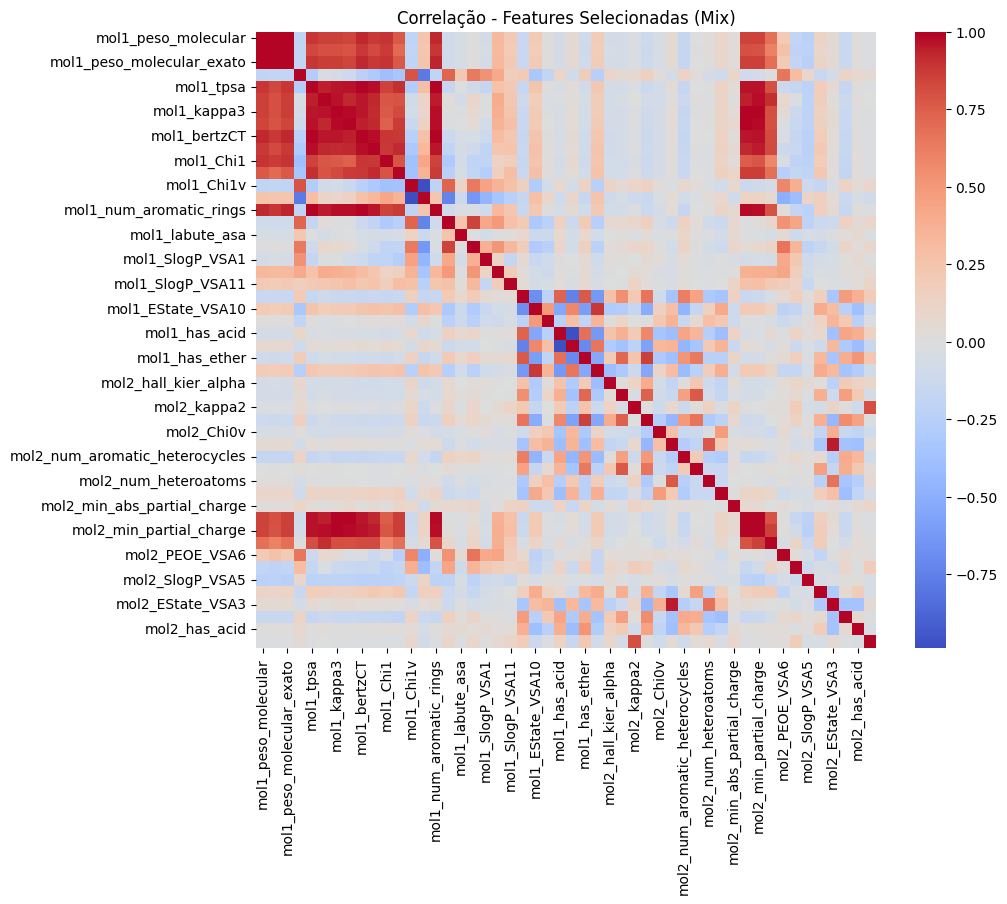

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_pure_sel.corr(), cmap='coolwarm', center=0)
plt.title('Correlação - Features Selecionadas (Pure)')
plt.show()
plt.figure(figsize=(10, 8))
sns.heatmap(df_mix_sel.corr(), cmap='coolwarm', center=0)
plt.title('Correlação - Features Selecionadas (Mix)')
plt.show()

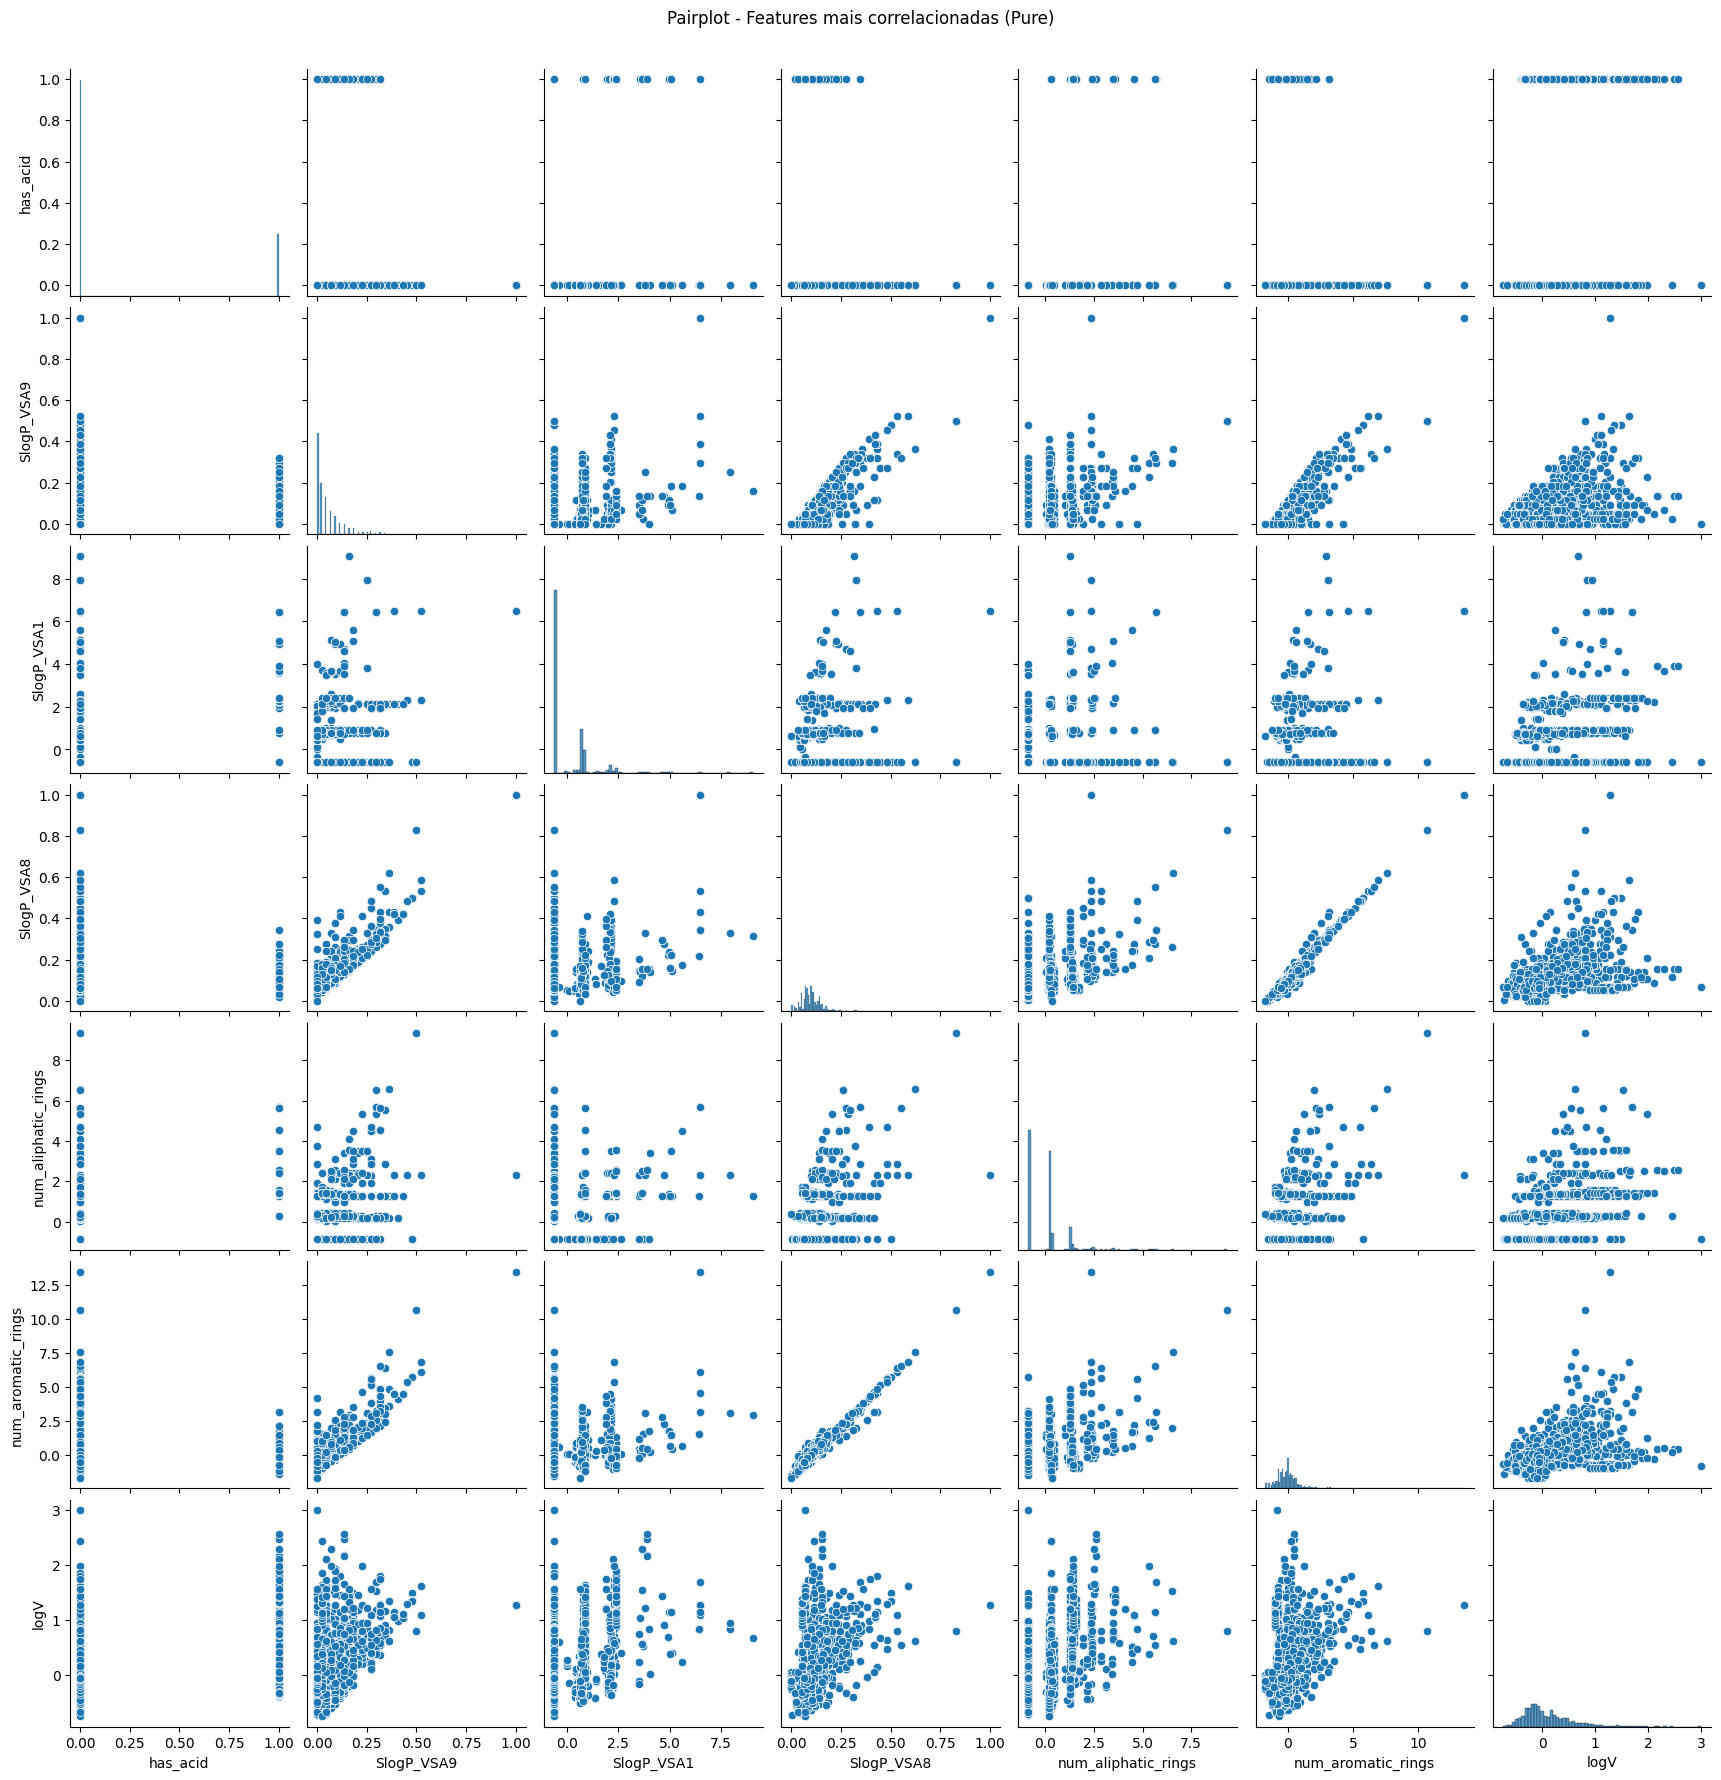

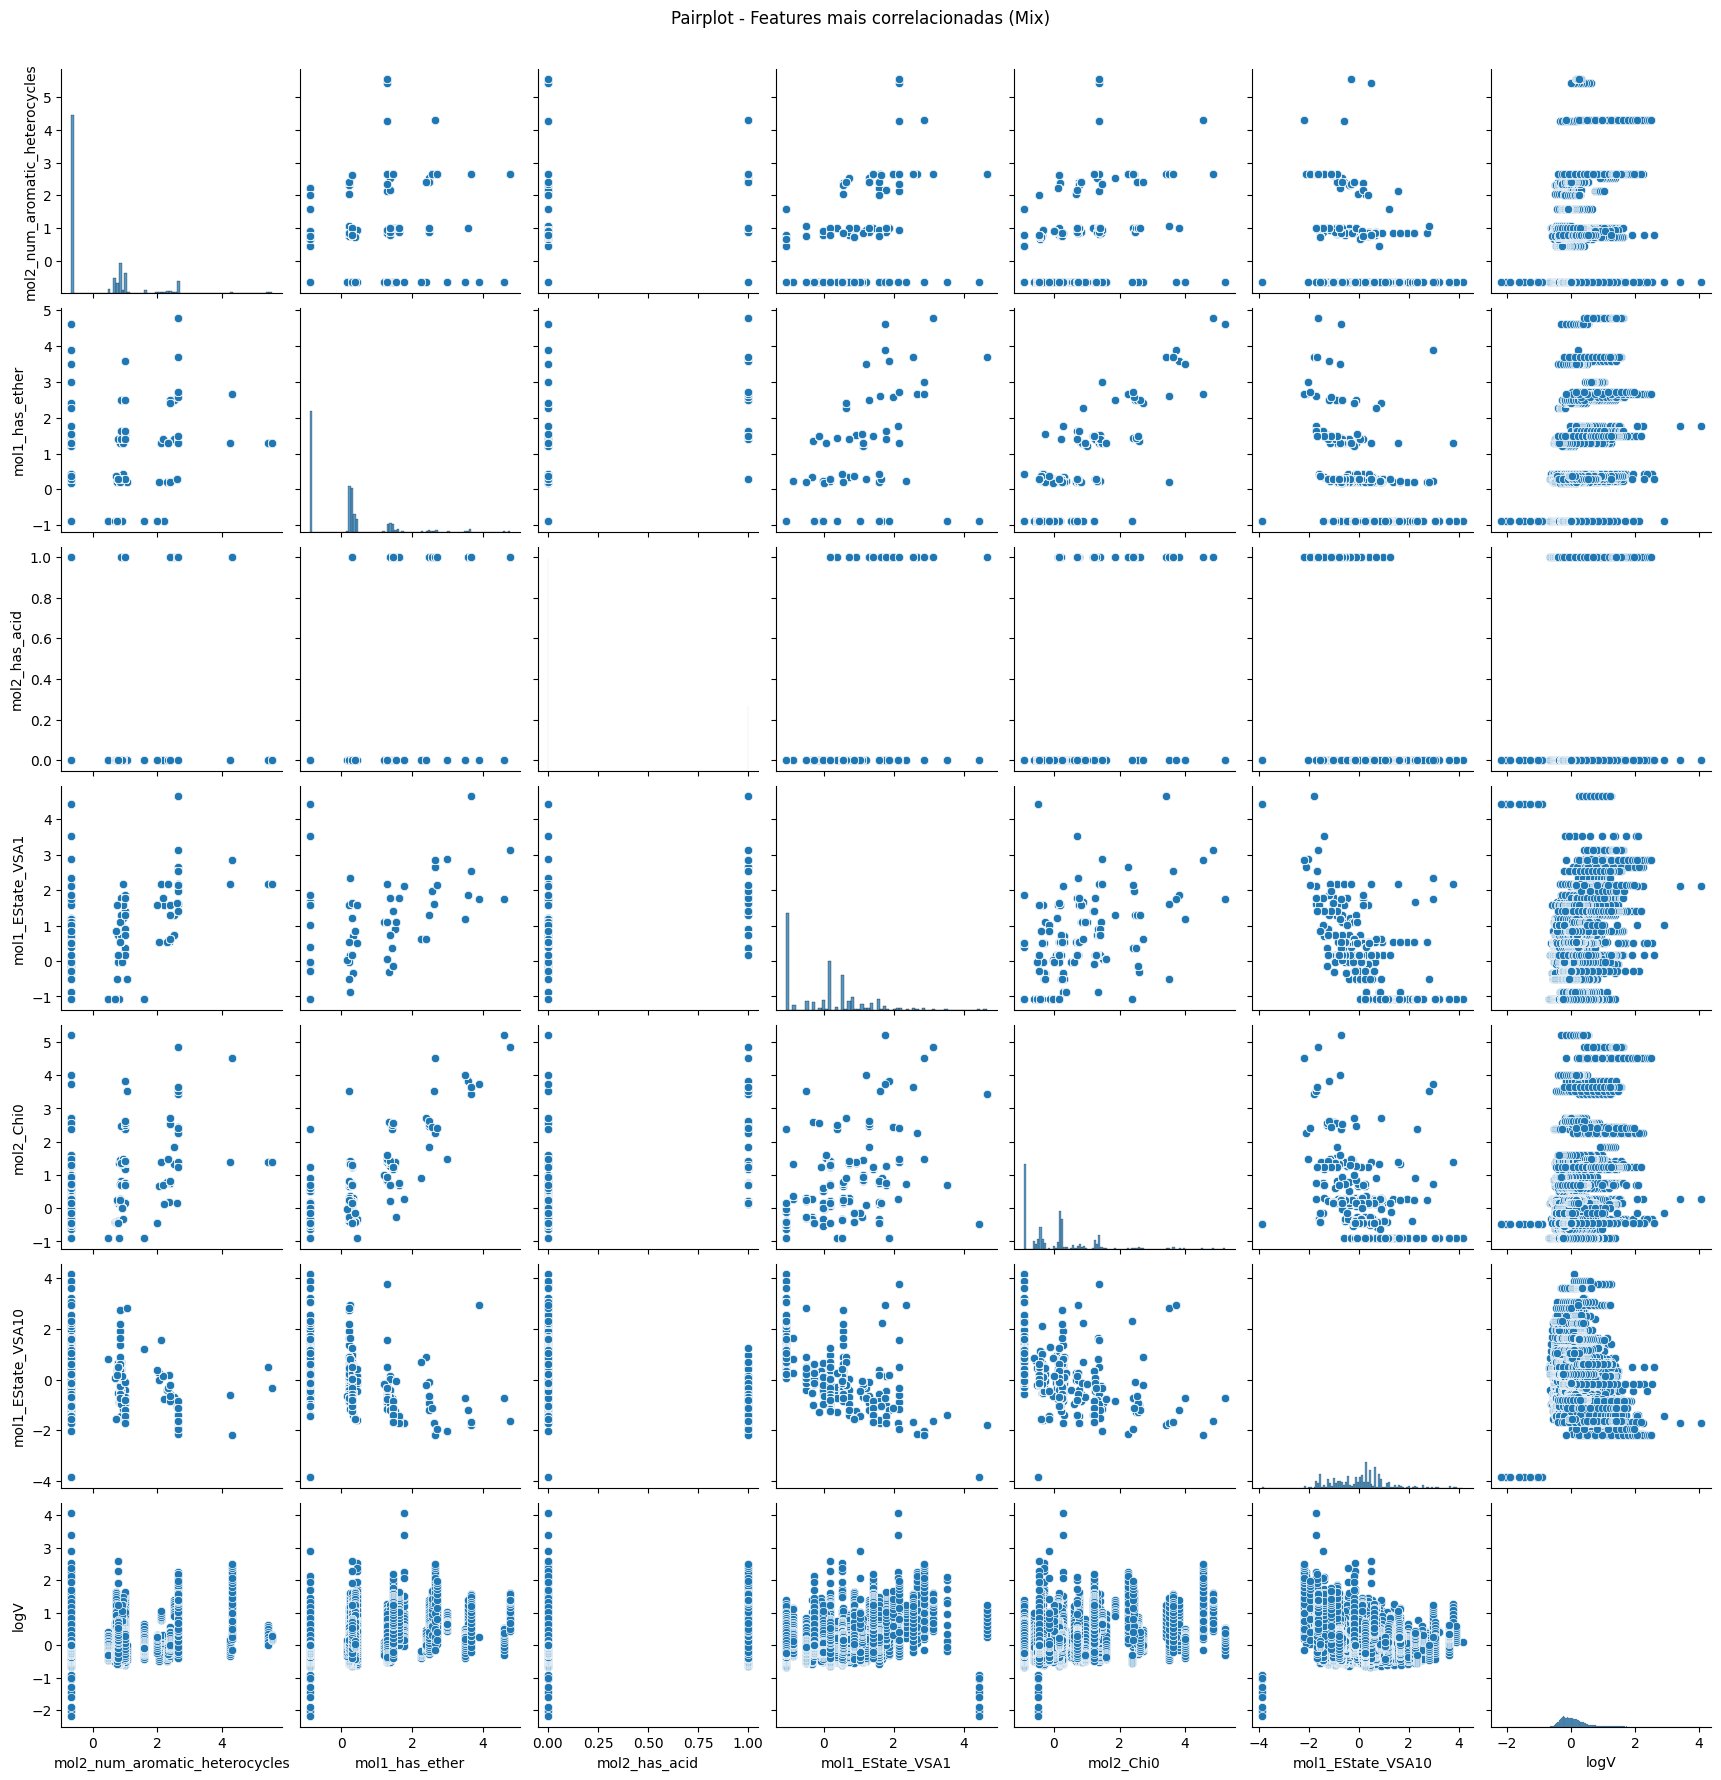

In [21]:
# Selecionar features mais correlacionadas com logV
corr_pure = abs(pd.concat([df_pure_sel, y_pure.reset_index(drop=True)], axis=1)).corr()['logV'].sort_values(ascending=False)
top_pure = corr_pure.index[1:7]

corr_mix = abs(pd.concat([df_mix_sel, y_mix.reset_index(drop=True)], axis=1)).corr()['logV'].sort_values(ascending=False)
top_mix = corr_mix.index[1:7]

sns.pairplot(pd.concat([df_pure_sel[top_pure], y_pure.reset_index(drop=True)], axis=1))
plt.suptitle("Pairplot - Features mais correlacionadas (Pure)", y=1.02)
plt.show()

sns.pairplot(pd.concat([df_mix_sel[top_mix], y_mix.reset_index(drop=True)], axis=1))
plt.suptitle("Pairplot - Features mais correlacionadas (Mix)", y=1.02)
plt.show()


Features mais correlacionadas com logV:
has_acid                   corr: +0.4958
eletrons_valencia          corr: +0.4937
num_aliphatic_rings        corr: +0.4825
PEOE_VSA12                 corr: +0.4407
SlogP_VSA9                 corr: +0.4200
SlogP_VSA8                 corr: +0.4146


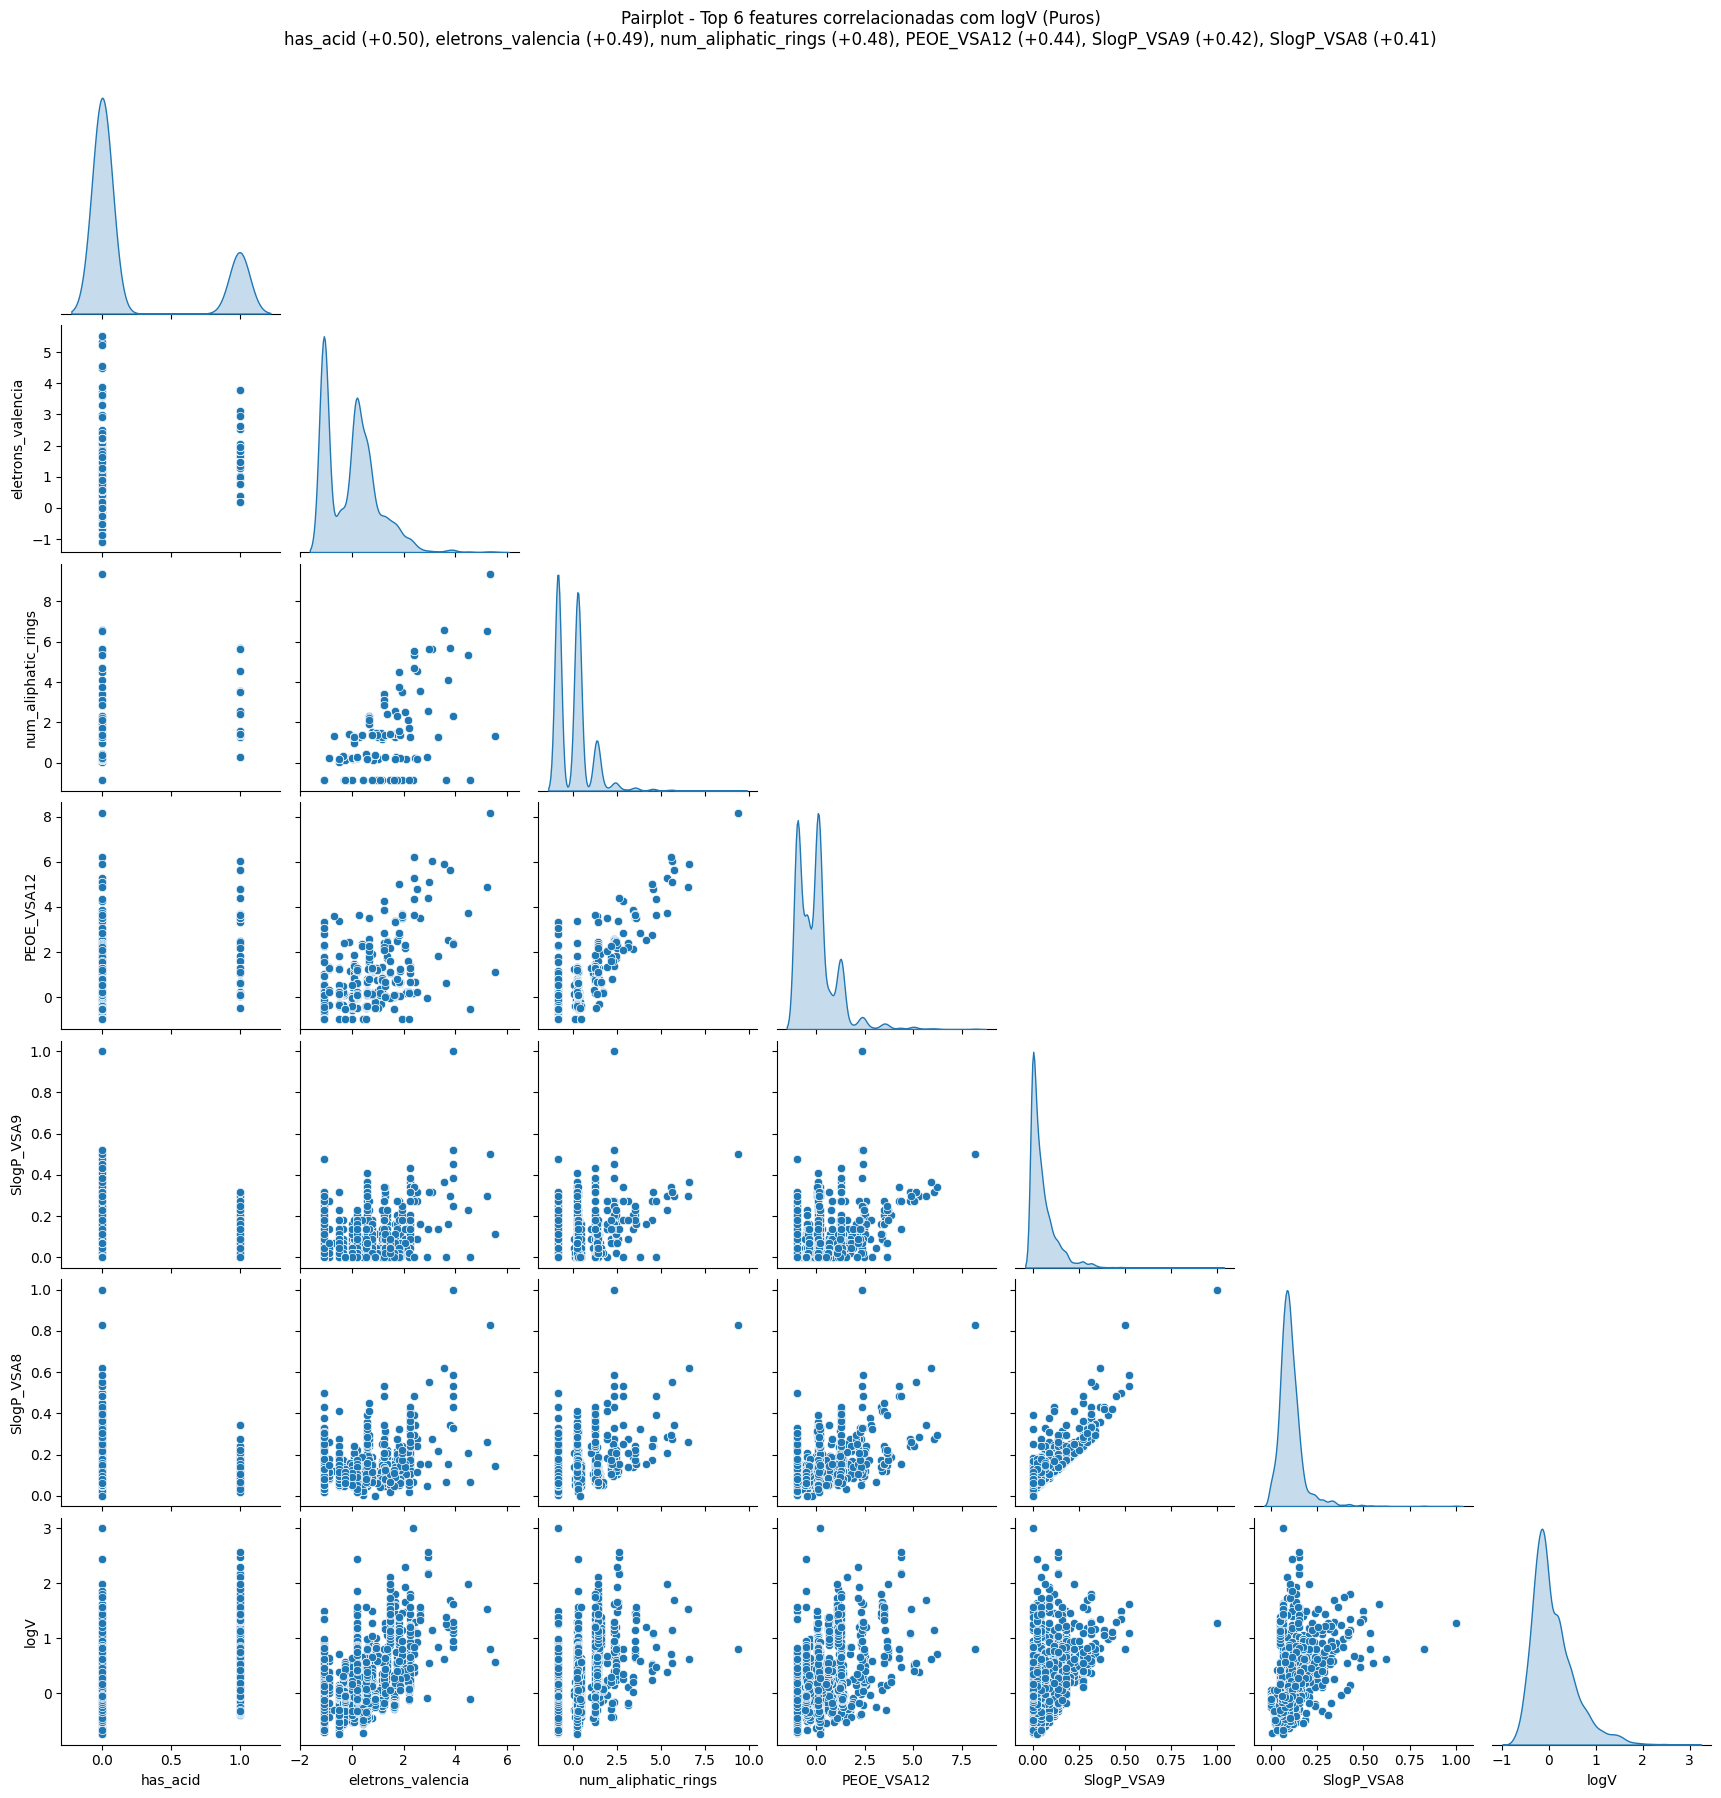

Features mais correlacionadas com logV:
mol1_has_ether             corr: +0.4641
mol1_EState_VSA1           corr: +0.4602
mol2_Chi0                  corr: +0.3741
mol1_num_aliphatic_rings   corr: +0.3608
mol2_has_acid              corr: +0.3436
mol1_has_urea              corr: -0.3413


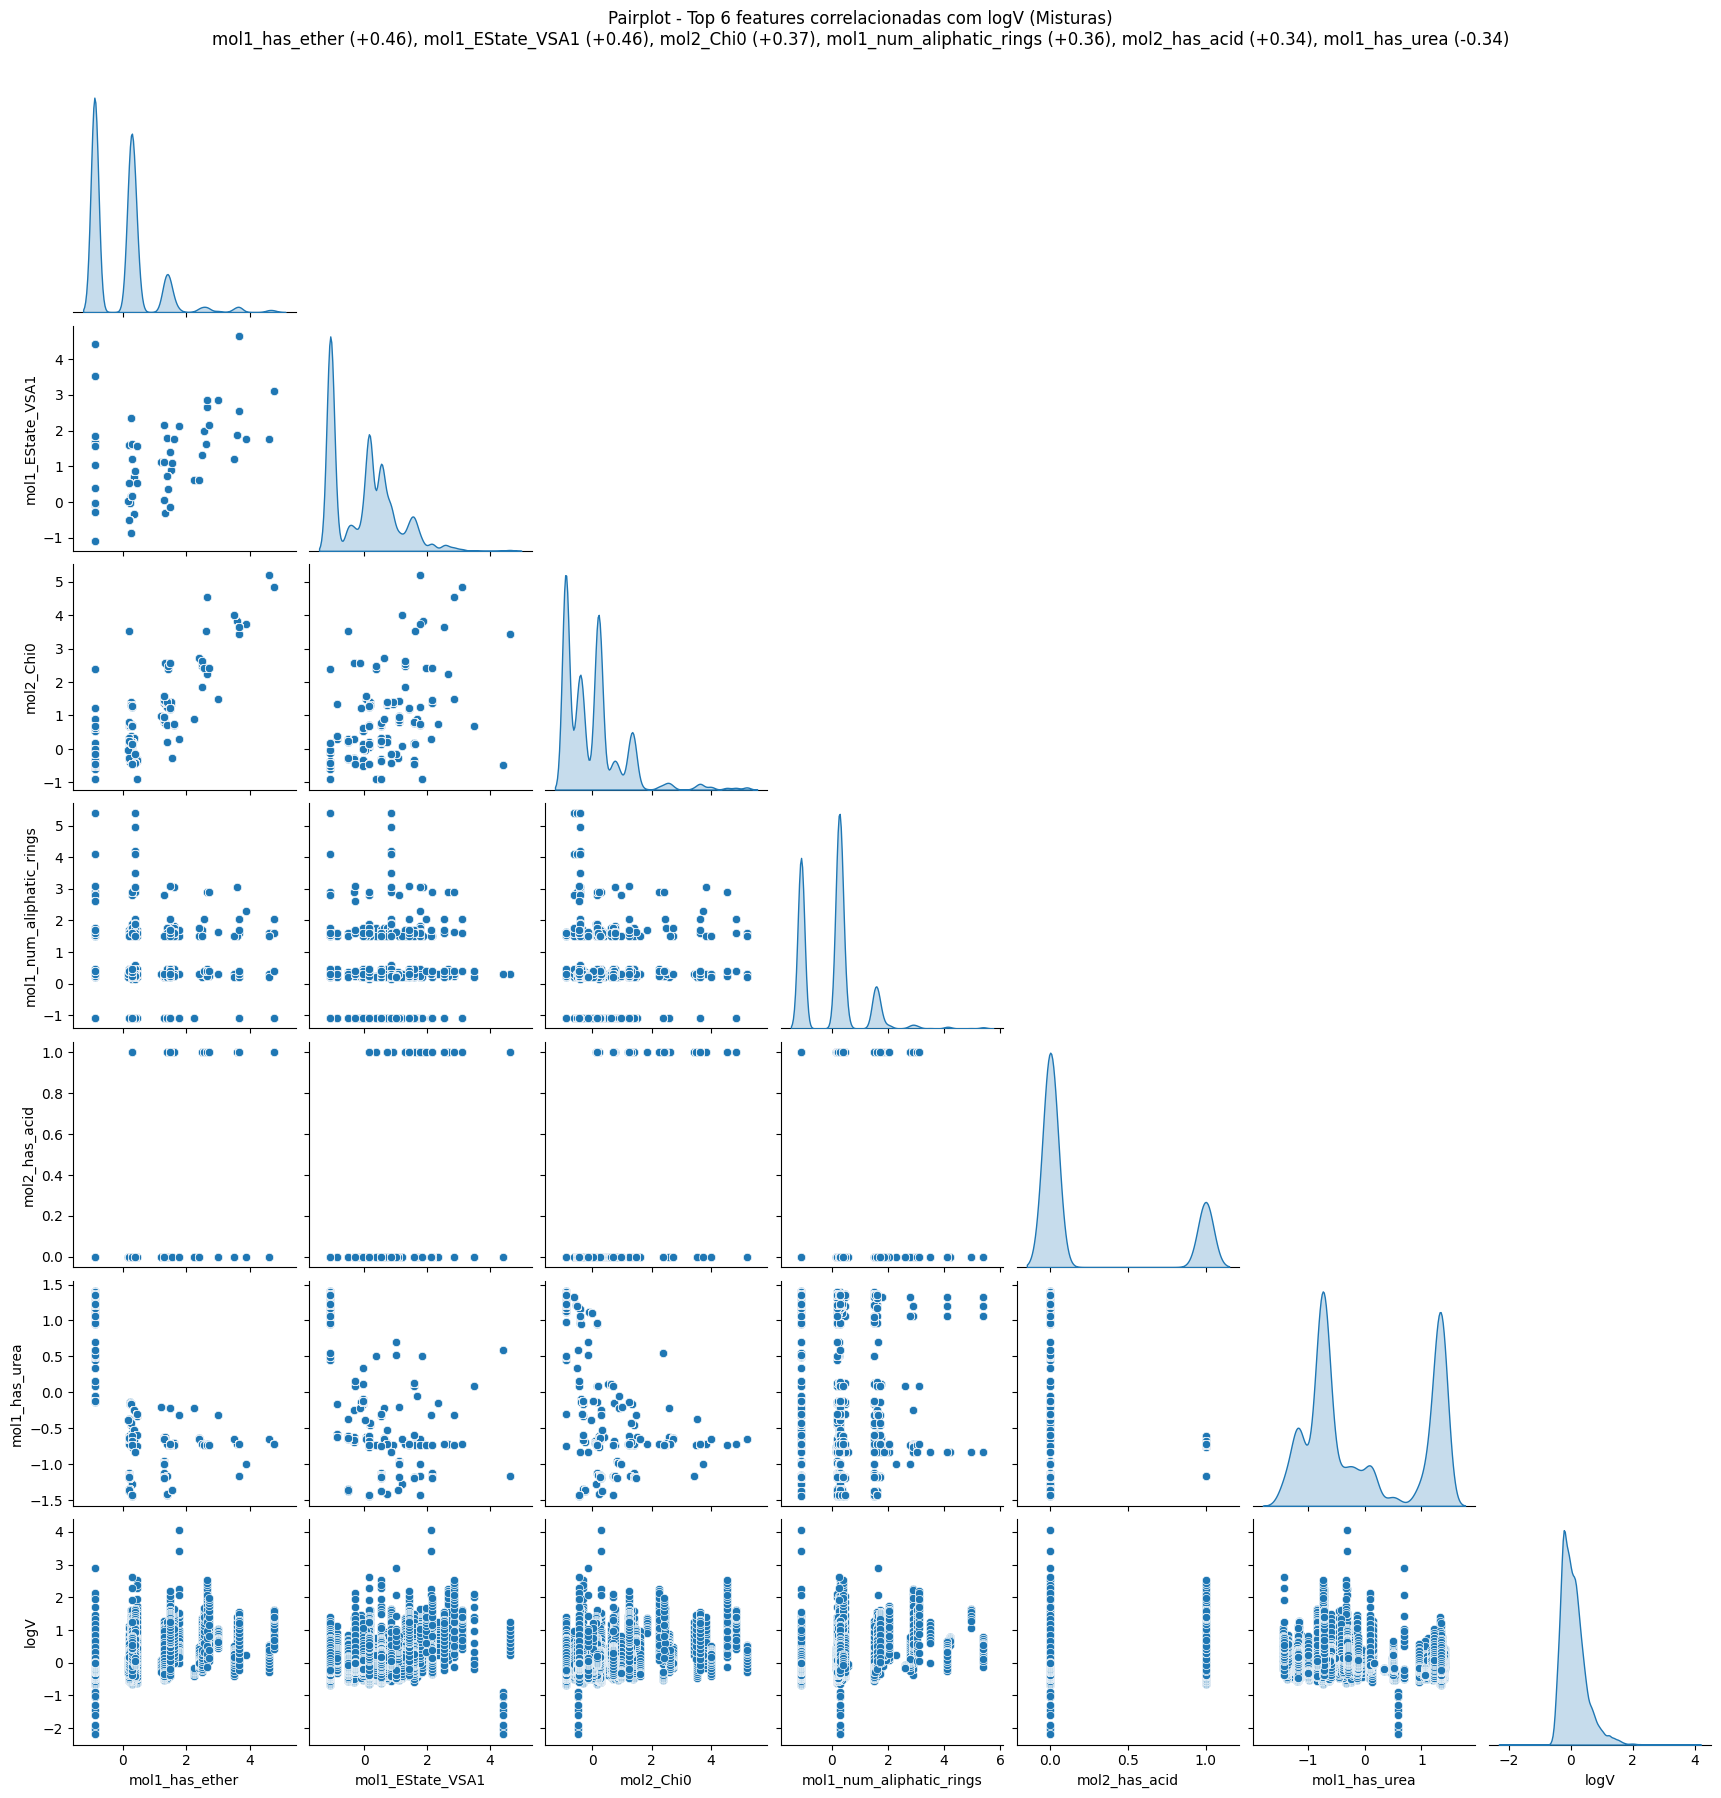

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_correlated_pairplot(df_features, y, top_n=6, title_suffix=""):
    df = pd.concat([df_features, y.reset_index(drop=True)], axis=1)
    corr = df.corr()['logV'].drop('logV').sort_values(key=lambda x: abs(x), ascending=False)

    top_features = corr.index[:top_n]
    corr_values = corr[:top_n].values

    print("Features mais correlacionadas com logV:")
    for f, c in zip(top_features, corr_values):
        print(f"{f:25s}  corr: {c:+.4f}")

    df_sel = df[top_features.tolist() + ['logV']]
    pair_plot = sns.pairplot(df_sel, hue=None, diag_kind="kde", corner=True)

    # Adicionar correlações no título
    coef_str = ", ".join([f"{f} ({c:+.2f})" for f, c in zip(top_features, corr_values)])
    plt.suptitle(f"Pairplot - Top {top_n} features correlacionadas com logV {title_suffix}\n{coef_str}",
                 y=1.03, fontsize=12)
    
    plt.show()


# exemplos de uso
plot_correlated_pairplot(df_pure_sel, y_pure, top_n=6, title_suffix="(Puros)")
plot_correlated_pairplot(df_mix_sel, y_mix, top_n=6, title_suffix="(Misturas)")
